# Materials for COP Presentation

## Background

---

## Description

Generate a range of materials on urbanisation and urban resilience.
 
   1. Bring in the WSF data
   2. Bring in Sentinel-2 data
   3. Calculate urban extent for years > 2015 using Sentinel-2
   4. Append the Sentinel-2 statistics to WSF and make a line chart for urban extent
   5. Bring in the Landsat geomedian and WOfS
   6. Generate an animation of WSF with geomedian greyscale and WOfS overlay
   7. Bring in ERA5 temperature data
   8. Generate trend analysis and graph

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [24]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
from datacube.utils.geometry import Geometry
from IPython.display import HTML

from skimage.filters import threshold_otsu
from statsmodels.tsa.seasonal import seasonal_decompose
from deafrica_tools.plotting import display_map
from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="cop")

### Analysis parameters

To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

The default location is Mansoura, Egypt.

In [5]:
# Method 1: Specify the latitude, longitude, and buffer
lat= 15.6
lon=32.5
buffer=0.2

# Get the latitude and longitude range of the geopolygon
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

### View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [ ]:
display_map(x=lon_range, y=lat_range)

## Loading of the WSF Evolution Dataset

In [6]:
#create reusable datacube query object
query_wsf = {
    'x': lon_range,
    'y': lat_range,
    'resolution':(-30, 30),
    'output_crs': 'epsg:6933',
}

#loading the data using dc.load
wsf_evolution = dc.load(product='wsf_evolution',
                        measurements=['wsfevolution', 'idc_score'],
                        **query_wsf).squeeze()

wsf_evolution

<xarray.Dataset>
Dimensions:       (y: 1641, x: 1287)
Coordinates:
    time          datetime64[ns] 2000-07-01T23:59:59.999500
  * y             (y) float64 1.991e+06 1.991e+06 ... 1.942e+06 1.942e+06
  * x             (x) float64 3.117e+06 3.117e+06 ... 3.155e+06 3.155e+06
    spatial_ref   int32 6933
Data variables:
    wsfevolution  (y, x) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    idc_score     (y, x) uint8 5 5 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5 5 5
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Load Landsat

In [7]:
query_ls = {
    'time': ('2016', '2023'),  # since wsf
    'x': lon_range,
    'y': lat_range,
    'resolution': (-30, 30),
    'measurements':['swir_1','swir_2','blue','green','red']

}

# Create a dataset of the requested data
geomedians = dc.load(product=['gm_ls8_annual', 'gm_ls8_ls9_annual'],
        output_crs='EPSG:6933',
        dask_chunks={'time': 1, 'x': 750, 'y': 750},
        **query_ls
).compute()

geomedians

<xarray.Dataset>
Dimensions:      (time: 7, y: 1641, x: 1287)
Coordinates:
  * time         (time) datetime64[ns] 2016-07-01T23:59:59.999999 ... 2022-07...
  * y            (y) float64 1.991e+06 1.991e+06 ... 1.942e+06 1.942e+06
  * x            (x) float64 3.117e+06 3.117e+06 ... 3.155e+06 3.155e+06
    spatial_ref  int32 6933
Data variables:
    swir_1       (time, y, x) uint16 4972 4967 4973 5039 ... 3157 3202 3261 3346
    swir_2       (time, y, x) uint16 4224 4221 4235 4315 ... 2781 2809 2870 2958
    blue         (time, y, x) uint16 913 915 917 921 925 ... 994 1004 1015 1047
    green        (time, y, x) uint16 1800 1803 1804 1811 ... 1548 1566 1580 1620
    red          (time, y, x) uint16 3087 3086 3095 3124 ... 2087 2116 2143 2197
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Calculate urban area with Sentinel-2

In [8]:
geomedians = calculate_indices(geomedians, index='ENDISI', satellite_mission='ls')

geomedians['ENDISI'] = geomedians.ENDISI.fillna(geomedians.ENDISI.mean().values)

threshold = threshold_otsu(geomedians.ENDISI.values)
print(round(threshold, 2))

urban_area = (geomedians.ENDISI > threshold).astype(int)

pixel_length = query_ls["resolution"][1]  # in metres
area_per_pixel = pixel_length**2 / 1000**2

urban_area_km2 = urban_area.sum(dim=['x', 'y']) * area_per_pixel

urban_area_km2

-0.35


<xarray.DataArray 'ENDISI' (time: 7)>
array([1199.6478, 1199.2023, 1098.5634, 1061.9568, 1052.0235, 1030.1022,
       1062.8325])
Coordinates:
  * time         (time) datetime64[ns] 2016-07-01T23:59:59.999999 ... 2022-07...
    spatial_ref  int32 6933

In [9]:
year = urban_area_km2.time.dt.year.to_dataframe()

s2_area = urban_area_km2.to_dataframe().set_index(year.year)

From the spatial plotting above, the left image shows the evolution from 1985 to 2015, while the right image indicates the IDC score for the study area. Looking at the IDC score of **6** for the area of study, the values obtained from the WSF Evolution data can be classified as **very good**, and one can rely on it for further analysis.

### Calculate the area of settlement footprint

The number of pixels can be used for the area of the building if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [11]:
pixel_length = query_wsf["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

### Plotting of the WSF Evolution data

Each pixel represents the year value of the WSF evolution dataset; to get the area of the evolution, the year pixel has to be counted and saved in a Pandas dataframe to enable calculation of the area. The cumulative sum of area will be calculated based on how it has increased over the period.

>Note that there is a discrepancy between the area calculated for 2015 from the WSF 2015 product and the Evolution product. This may be because the Evolution product is derived from Landsat-5 and Landsat-7, whereas WSF 2015 and 2019 are derived from Sentinel-1 and Landsat-8.

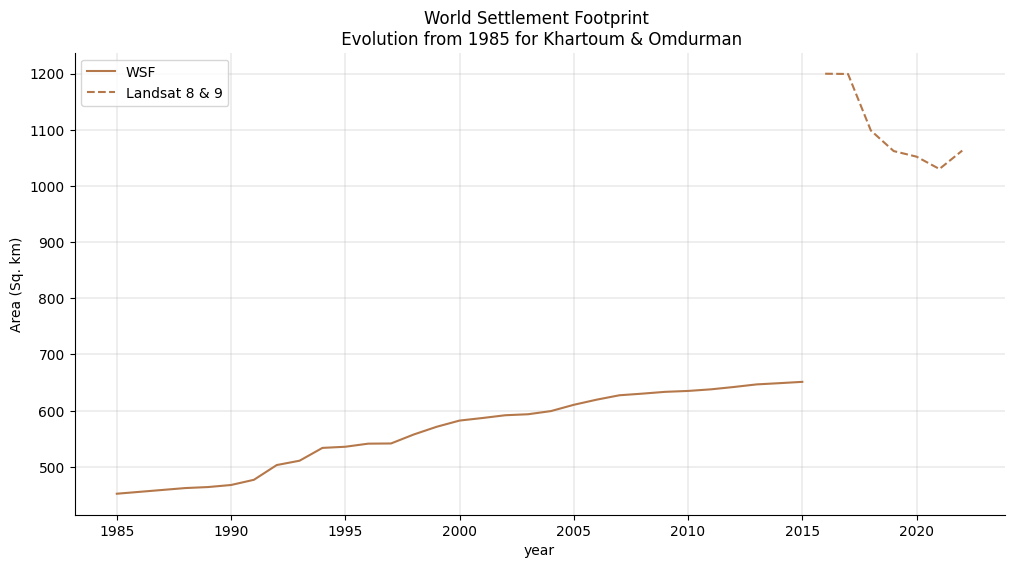

In [15]:
evolution_period = {}
#running a for loop to extract year and calculate the area based on the year
for evolution_year in np.unique(wsf_evolution.wsfevolution.values):
    if evolution_year != 0:
        evolution_area = wsf_evolution.where(
            wsf_evolution.wsfevolution ==evolution_year).wsfevolution.count() * area_per_pixel
        evolution_period[evolution_year] = evolution_area

#convert dict to dataframe
evolution_data = pd.DataFrame.from_dict(evolution_period, orient='index', dtype=float)

#Cummulative sum of the data
evolution_data['evolve'] = evolution_data[0].cumsum()

fig, ax = plt.subplots(figsize=(12,6))

evolution_data.evolve.plot(ax=ax, color='#B5784A')
s2_area.ENDISI.plot(ax=ax, linestyle='dashed', color='#B5784A')

custom_lines = [Line2D([0], [0], color='#B5784A'),
                Line2D([0], [0], color='#B5784A', linestyle='dashed')]

ax.legend(custom_lines, ['WSF', 'Landsat 8 & 9'])
ax.set_ylabel("Area (Sq. km)")
ax.set_title(f"World Settlement Footprint \n Evolution from 1985 for Khartoum & Omdurman")
ax.grid(linewidth=0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.savefig('Khartoum_area_ls.png')
plt.show()

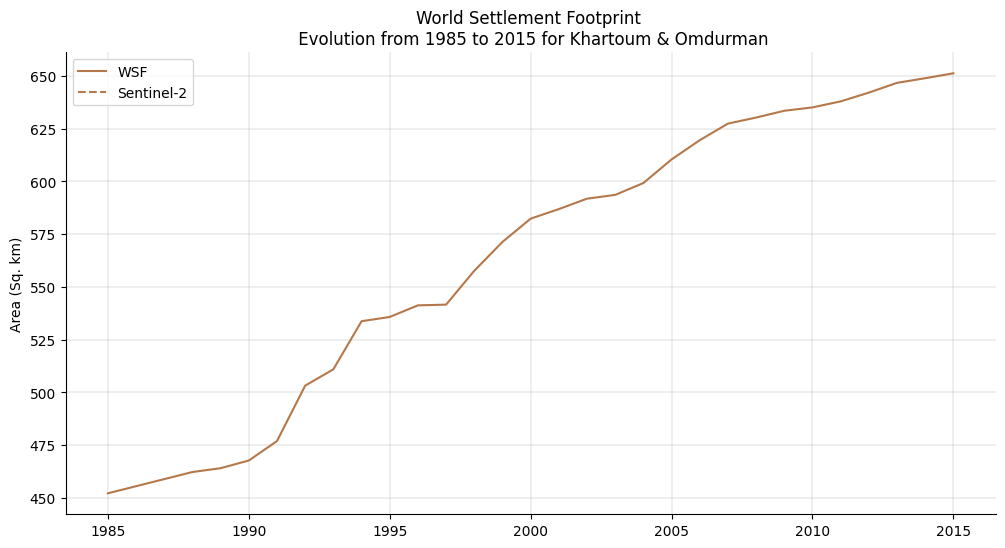

In [16]:
evolution_period = {}
#running a for loop to extract year and calculate the area based on the year
for evolution_year in np.unique(wsf_evolution.wsfevolution.values):
    if evolution_year != 0:
        evolution_area = wsf_evolution.where(
            wsf_evolution.wsfevolution ==evolution_year).wsfevolution.count() * area_per_pixel
        evolution_period[evolution_year] = evolution_area

#convert dict to dataframe
evolution_data = pd.DataFrame.from_dict(evolution_period, orient='index', dtype=float)

#Cummulative sum of the data
evolution_data['evolve'] = evolution_data[0].cumsum()

fig, ax = plt.subplots(figsize=(12,6))

evolution_data.evolve.plot(ax=ax, color='#B5784A')

ax.legend(custom_lines, ['WSF', 'Sentinel-2'])
ax.set_ylabel("Area (Sq. km)")
ax.set_title(f"World Settlement Footprint \n Evolution from 1985 to 2015 for Khartoum & Omdurman")
ax.grid(linewidth=0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.savefig('Khartoum_area_line.png')
plt.show()

### Animation of WSF Evolution data from 1985 to 2015
The cell below plots out the dataset and shows the animation of how the building footprint has evolved over the years from 1985 to 2015.

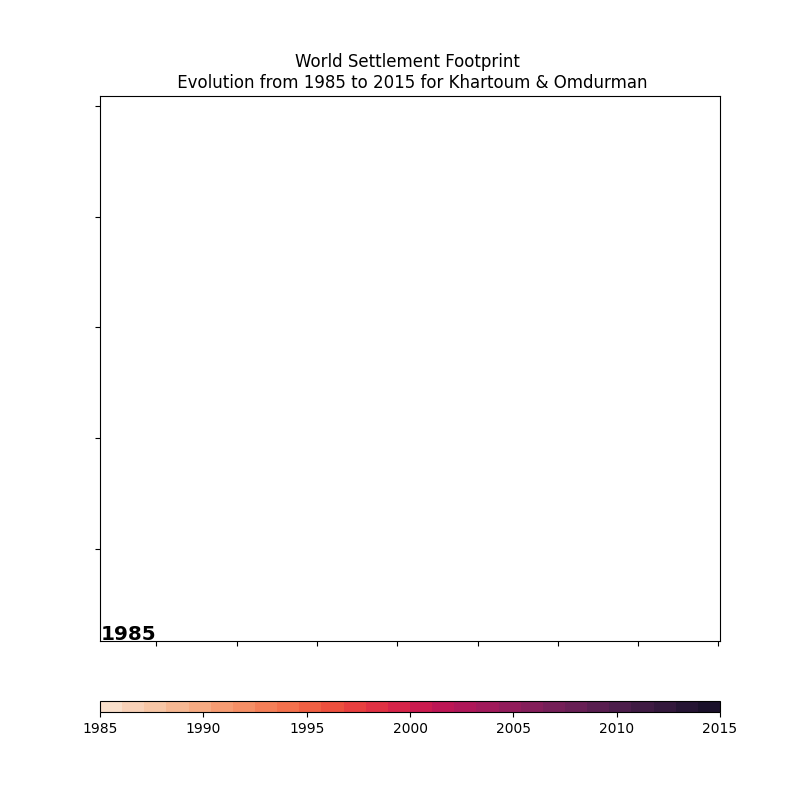

In [17]:
evolution_year = evolution_data.index.values
fig, ax = plt.subplots(figsize=(8,8))

#Generating the color scheme based on the number of years
lenyear=len(evolution_year)
palette = list(reversed(sns.color_palette("rocket", lenyear).as_hex()))
wsf = []
color_index = 0
for i in range(1, len(evolution_year) + 1):
    evo_list= (evolution_year[:i])
    color = palette[:color_index]
    wsf_plt = wsf_evolution.where(
        wsf_evolution.isin(evo_list)).wsfevolution.plot(cmap=ListedColormap(color),
                                                 add_colorbar= False, ax=ax)
    color_index += 1
    t = ax.annotate(evolution_year[i-1], (1,1), xycoords='axes pixels', size='x-large',
                    weight='bold') 
    wsf.append([wsf_plt, t])

ax.set_title(f'World Settlement Footprint \n Evolution from 1985 to 2015 for Khartoum & Omdurman')
ax.set_xticklabels("")
ax.set_yticklabels("")
ax.set_ylabel("")
ax.set_xlabel("")

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='2%', pad=0.6, pack_start = True)
fig.add_axes(cax)
fig.colorbar(wsf_plt, cax = cax, orientation = 'horizontal')

ani = animation.ArtistAnimation(fig=fig, artists=wsf, interval=500, blit=True)
ani.save('Khartoum_blank.gif')
plt.close()

Image(filename='Khartoum_blank.gif')

## Bring in geomedian

In [18]:
ds = dc.load(product=["gm_ls5_ls7_annual", "gm_ls8_annual","gm_ls8_ls9_annual"],
             measurements=['red', 'green', 'blue'],
             x=lon_range,
             y=lat_range,
             resolution = (-30,30),
             dask_chunks={'time': 1, 'x': 3000, 'y': 3000},
             time= ('2015-12-31')
             ).compute()

ds['gr'] = (ds.red + ds.green + ds.blue)/3

<xarray.Dataset>
Dimensions:      (time: 1, y: 1641, x: 1287)
Coordinates:
  * time         (time) datetime64[ns] 2015-07-02T11:59:59.999999
  * y            (y) float64 1.991e+06 1.991e+06 ... 1.942e+06 1.942e+06
  * x            (x) float64 3.117e+06 3.117e+06 ... 3.155e+06 3.155e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 3128 3119 3129 3168 ... 2283 2296 2304 2300
    green        (time, y, x) uint16 1807 1803 1807 1823 ... 1675 1681 1685 1686
    blue         (time, y, x) uint16 929 930 931 937 941 ... 1081 1087 1085 1083
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [20]:
wofs_alltime = dc.load(product='wofs_ls_summary_alltime',
               like=ds.geobox)

wofs_alltime

<xarray.Dataset>
Dimensions:      (time: 1, y: 1641, x: 1287)
Coordinates:
  * time         (time) datetime64[ns] 2003-07-02T11:59:59.999999
  * y            (y) float64 1.991e+06 1.991e+06 ... 1.942e+06 1.942e+06
  * x            (x) float64 3.117e+06 3.117e+06 ... 3.155e+06 3.155e+06
    spatial_ref  int32 6933
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 2 2 0 1 6 8 3 2 2 0
    count_clear  (time, y, x) int16 1476 1473 1470 1457 1465 ... 794 796 798 793
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.002513 0.002506 0.0
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref

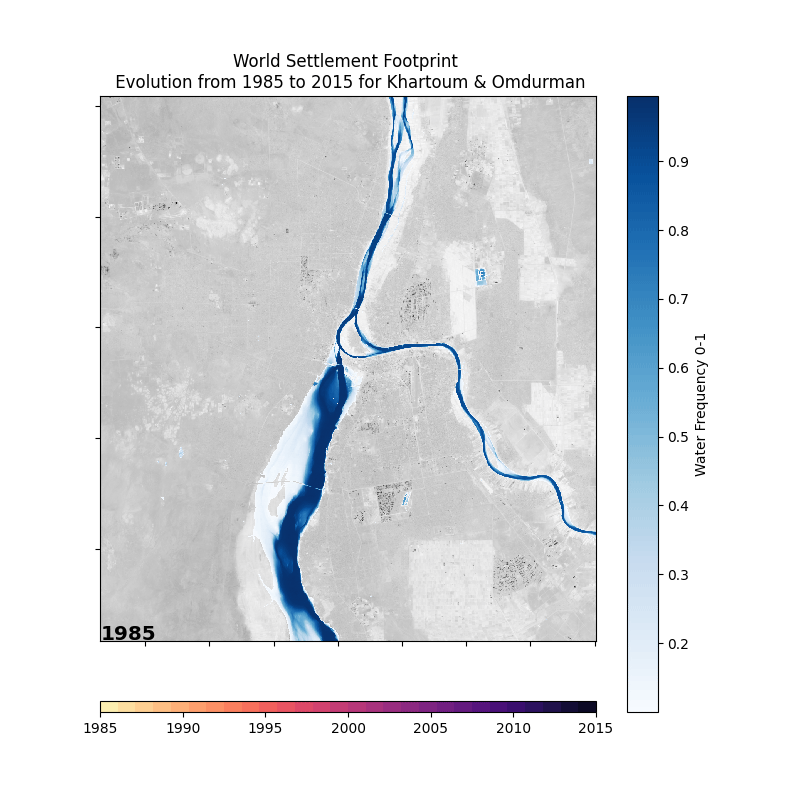

In [21]:
evolution_year = evolution_data.index.values
fig, ax = plt.subplots(figsize=(8, 8))

bands=['gr_red', 'gr_green', 'gr_blue']

cax = ds.gr.plot(cmap='Greys', add_colorbar= False, ax=ax)
dax = wofs_alltime.frequency.where(wofs_alltime.frequency>0.1).plot(cmap='Blues', ax=ax,
    cbar_kwargs={
        'extend':'neither',
        'label':'Water Frequency 0-1'
    })

#Generating the color scheme based on the number of years
lenyear=len(evolution_year)
palette = list(reversed(sns.color_palette("magma", lenyear).as_hex()))
wsf = []
color_index = 0
for i in range(1, len(evolution_year) + 1):
    evo_list= (evolution_year[:i])
    color = palette[:color_index]
    wsf_plt = wsf_evolution.where(
        wsf_evolution.isin(evo_list)).wsfevolution.plot(cmap=ListedColormap(color),
                                                 add_colorbar= False, ax=ax)
    color_index += 1
    t = ax.annotate(evolution_year[i-1], (1,1), xycoords='axes pixels', size='x-large',
                    weight='bold') 
    wsf.append([wsf_plt, t])

ax.set_title(f'World Settlement Footprint \n Evolution from 1985 to 2015 for Khartoum & Omdurman')
ax.set_xticklabels("")
ax.set_yticklabels("")
ax.set_ylabel("")
ax.set_xlabel("")

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='2%', pad=0.6, pack_start = True)
fig.add_axes(cax)
fig.colorbar(wsf_plt, cax = cax, orientation = 'horizontal')

ani = animation.ArtistAnimation(fig=fig, artists=wsf, interval=500, blit=True)
ani.save('Khartoum_background.gif')
plt.close()

Image(filename='Khartoum_background.gif')

## Bring in ERA5

In [35]:
var = "air_temperature_at_2_metres"
time = '1985-01', '2021-12'

temp = load_era5(var, lat_range, lon_range, time, reduce_func=np.mean, resample='1M').compute()

attrs = temp[var].attrs
attrs["units"] = "C"
temp = temp - 273.15  # convert from Kelvin to Celcius
temp[var].attrs = attrs

#

In [36]:
temp

<xarray.Dataset>
Dimensions:                      (lat: 2, lon: 3, time: 444)
Coordinates:
  * lat                          (lat) float32 15.75 15.5
  * lon                          (lon) float32 32.25 32.5 32.75
  * time                         (time) datetime64[ns] 1985-01-31 ... 2021-12-31
    spatial_ref                  int32 4326
Data variables:
    air_temperature_at_2_metres  (time, lat, lon) float32 23.7 24.34 ... 24.97
Attributes:
    institution:   ECMWF
    source:        Reanalysis
    tilte:         ERA5 forecasts
    title:         ERA5 forecasts
    grid_mapping:  spatial_ref

In [37]:
temp_air_ts = temp[var].mean(['lat','lon']).to_pandas()

In [38]:
temp_air_dts = seasonal_decompose(temp_air_ts)

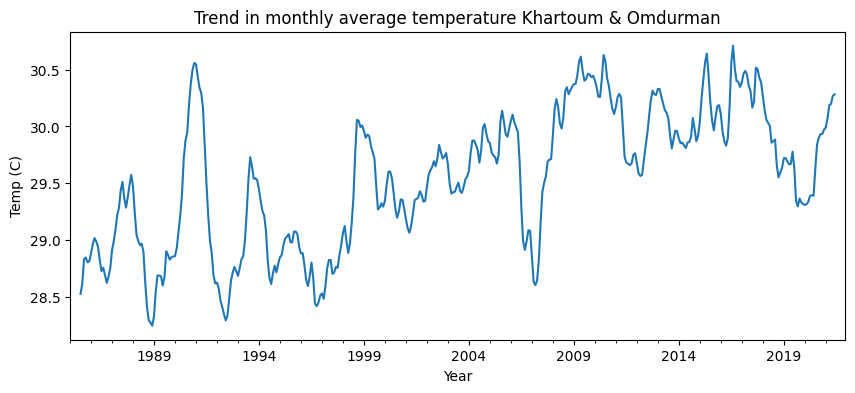

In [40]:
temp_air_dts.trend.plot(figsize = (10,4))
plt.xlabel('Year')
plt.ylabel('%s (%s)'%('Temp', temp[var].attrs['units']))
plt.title('Trend in monthly average temperature Khartoum & Omdurman')
plt.savefig('Khartoum_temp_trend.png');

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')